In [130]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import astropy.io.ascii as aia
import bz2
import glob
import pickle
import pystan
import re
import scipy.optimize as so
import scipy.stats as ss
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


Some $\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
\newcommand{\Mini}{M_\mathrm{ini}}
\newcommand{\MSun}{M_\odot}
\newcommand{\Myr}{\mathrm{Myr}}
$$

# Re-Analysis of Schneider+ IMF Data

## Setup, Model

[Schneider, et al. (2018)](https://dx.doi.org/10.1126/science.aan0106) report on an analysis of the stellar parameters of massive stars in 30 Dor that suggests that the high-mass end of the IMF contains more stars than suggested by a Salpeter IMF (i.e. the power-law is shallower than $\diff{N}{M} \propto M^{-2.35}$, more like $\diff{N}{M} \propto M^{-1.9}$).  However, their analysis rests on summing the posteriors of stellar parameters for their sample of observed stars!  Therefore, the distributions they obtain for stellar ages and stellar masses represent the *convolution* of the true distributions for these quantities with observational errors (see, e.g. [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract)); convolving a (broad---See Fig 1 from Schneider, et al. (2018)) observational uncertainty with a steep power law tends to shallow the power law at the high mass end, suggesting that their differences with Salpeter may (at least partly) be a result of their flawed statistical approach.

Schneider, et al. (2018) should be *commended* for providing the data from their stellar parameter fits.  I downloaded the data.  Then I realised they should also be *reprimanded* for not using a truly machine-readable format!  But no matter; by reading the header and manually putting in column names, I can parse it:

In [2]:
stellar_parameters_all = genfromtxt('aan0106_Data_S1.txt', delimiter='\t', comments='#', usecols=(2,3,4,10,11,12,23,24,25,31,32,33), names=('logL', 'dlogLp', 'dlogLm', 'logg', 'dloggp', 'dloggm', 'Mini', 'dMinip', 'dMinim', 'age', 'dagep', 'dagem'))

sel = np.ones(stellar_parameters_all.shape[0], dtype=np.bool)

for n in stellar_parameters_all.dtype.names:
    sel = sel & ~(np.isnan(stellar_parameters_all[n]))

stellar_parameters = stellar_parameters_all[sel]

Here is the data:

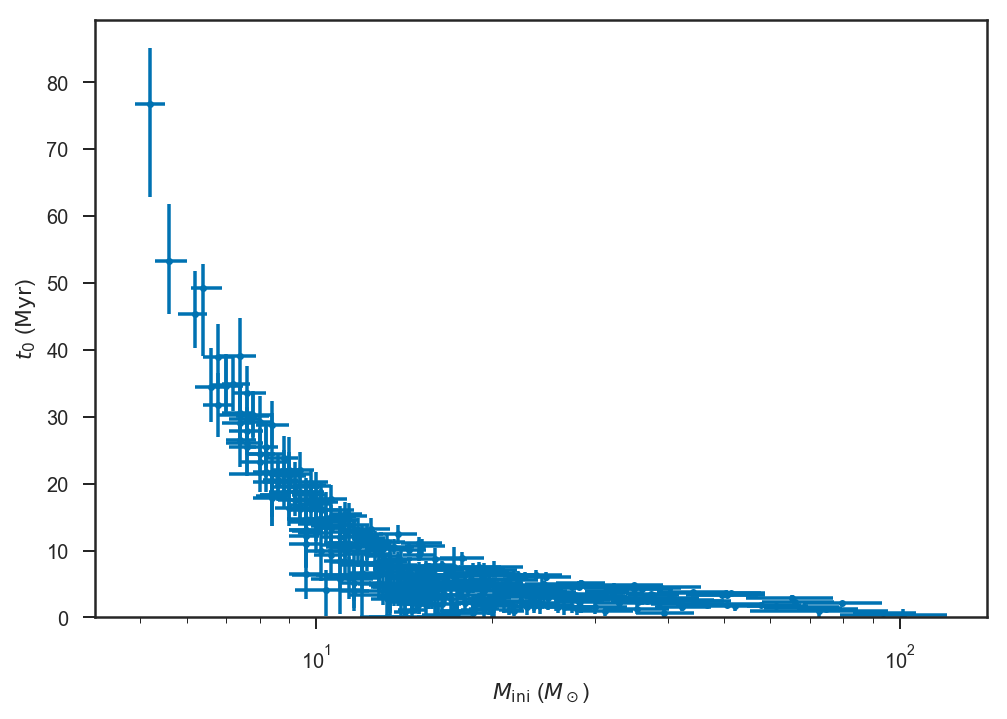

In [3]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', )
axis(ymin=0)
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
savefig('age-mass-all.pdf')

In [4]:
len(stellar_parameters_all), len(stellar_parameters)

(572, 387)

And restricting to $\Mini \geq 15 \, \MSun$:

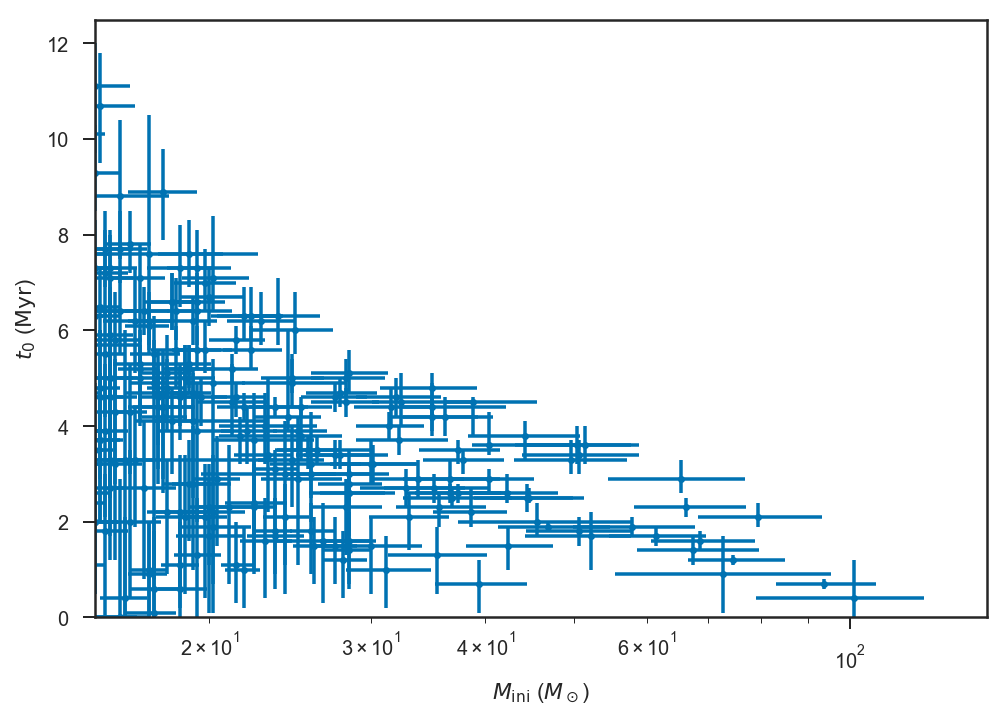

In [5]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.')
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=15, ymin=0, ymax=12.5)
savefig('age-mass-zoom.pdf')

I grabbed the non-rotating evolutionary models from [Brott, et al. (2011)](https://dx.doi.org/10.1051/0004-6361/201016113) from [VizieR](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/530/A115#sRM2.1).  I also grabbed `models.dat`, which gives the masses for the models.

Since 30 Dor has a metallicity around half the solar value, I think it is probably best to use the LMC lifetimes.

In [6]:
masses = []
lifetimes = []
for f in glob.glob('evol/f*.dat'):
    m = float(int(re.match('.*f([0-9]+)-.*', f).group(1)))
    lt = np.max(genfromtxt(f, delimiter='|', usecols=(0,)))
    masses.append(m)
    lifetimes.append(lt)
masses = array(masses)
lifetimes = array(lifetimes)
inds = argsort(masses)
masses = masses[inds]
lifetimes = lifetimes[inds]

The plot below is restricted to $M \geq 15 \, \MSun$.

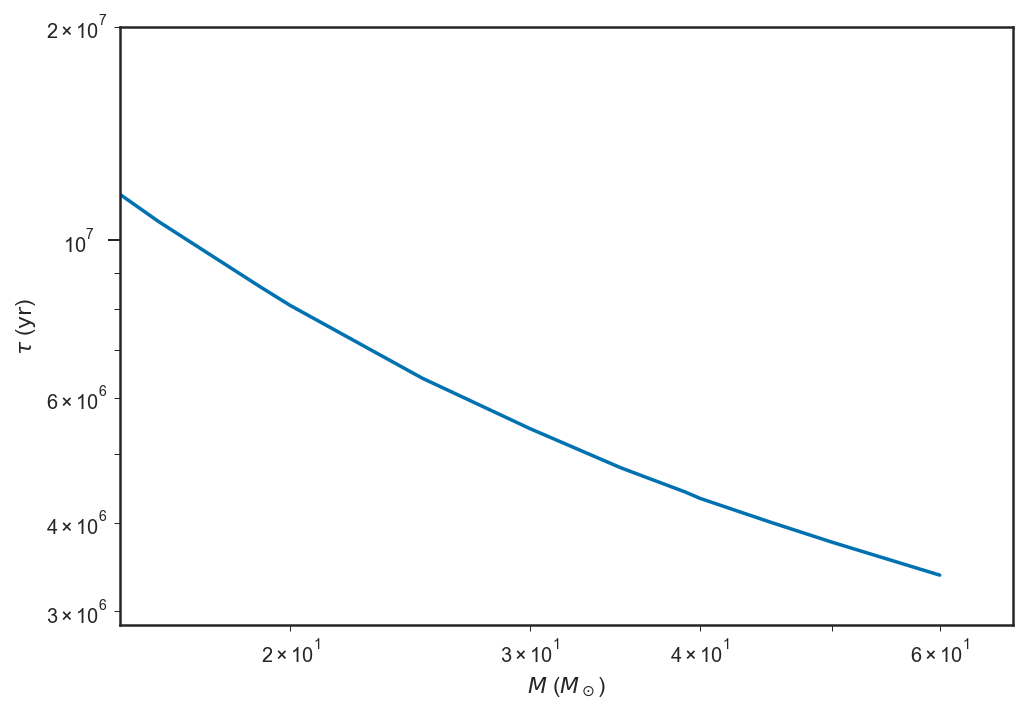

In [7]:
plot(masses, lifetimes)
xscale('log')
yscale('log')
axis(xmin=15, ymax=2e7)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

Let's try to interpret this as a power law (it's not, clearly, but maybe it's close).  Hmm, doesn't look too good:

(15, 57.23700725928984, -1.4, -0.50835948614594062)

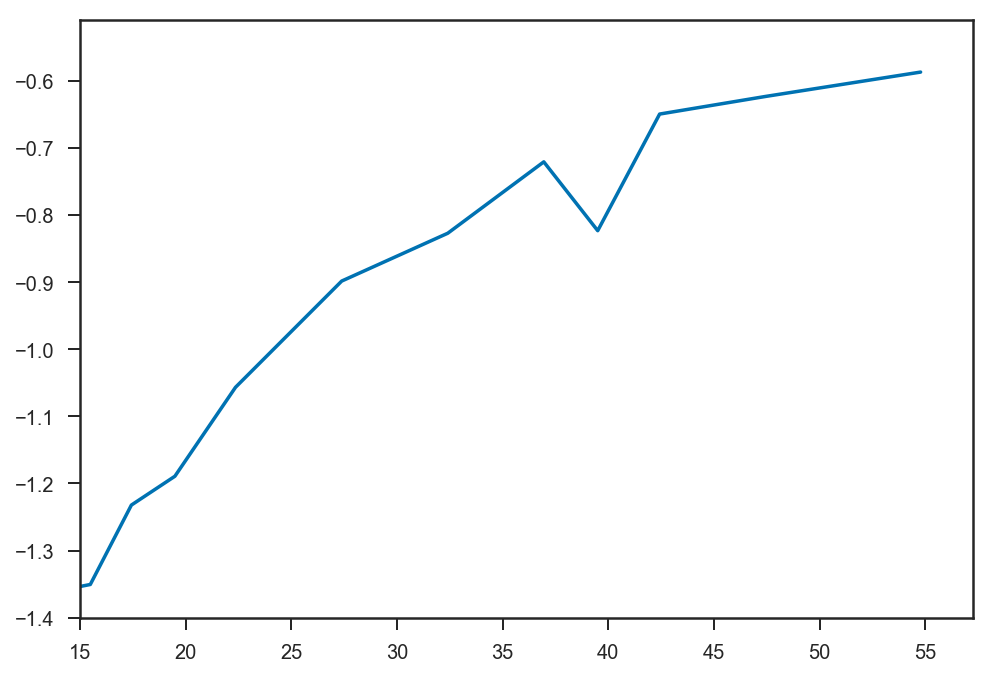

In [8]:
mid_masses = exp(0.5*(log(masses[1:]) + log(masses[:-1])))
plot(mid_masses, diff(log(lifetimes))/diff(log(masses)))
axis(xmin=15, ymin=-1.4)

OK.  How about a log-log fit to polynomials?

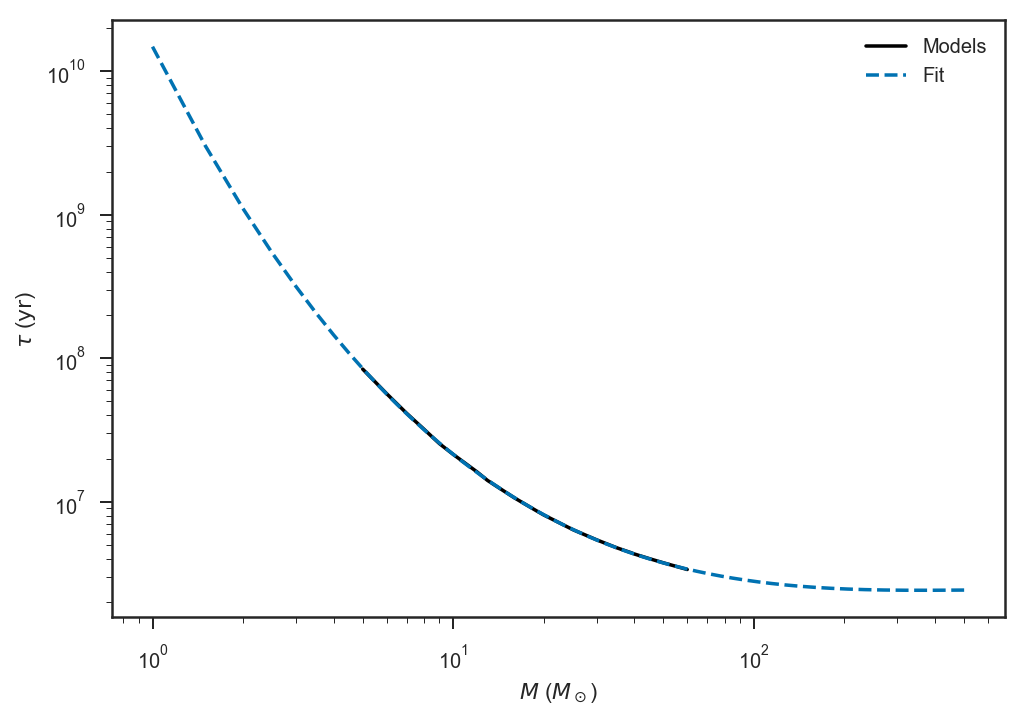

In [9]:
nmasses = masses.shape[0]
M = column_stack((ones(nmasses), log(masses), log(masses)**2, log(masses)**3))
c_lifetime = np.linalg.lstsq(M, log(lifetimes/1e6))[0]
plot(masses, lifetimes, '-k', label='Models')

fit_masses = linspace(1, 500, 1000)
Mfit = column_stack((ones(1000), log(fit_masses), log(fit_masses)**2, log(fit_masses)**3))

plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T))*1e6, '--', label='Fit')
xscale('log')
yscale('log')

legend(loc='best')

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

savefig('lifetime-fit.pdf')

In [108]:
def lifetime(M, cs):
    return np.exp(np.dot([1.0, log(M), log(M)**2, log(M)**3], cs))

Let's compare against the observed sample:

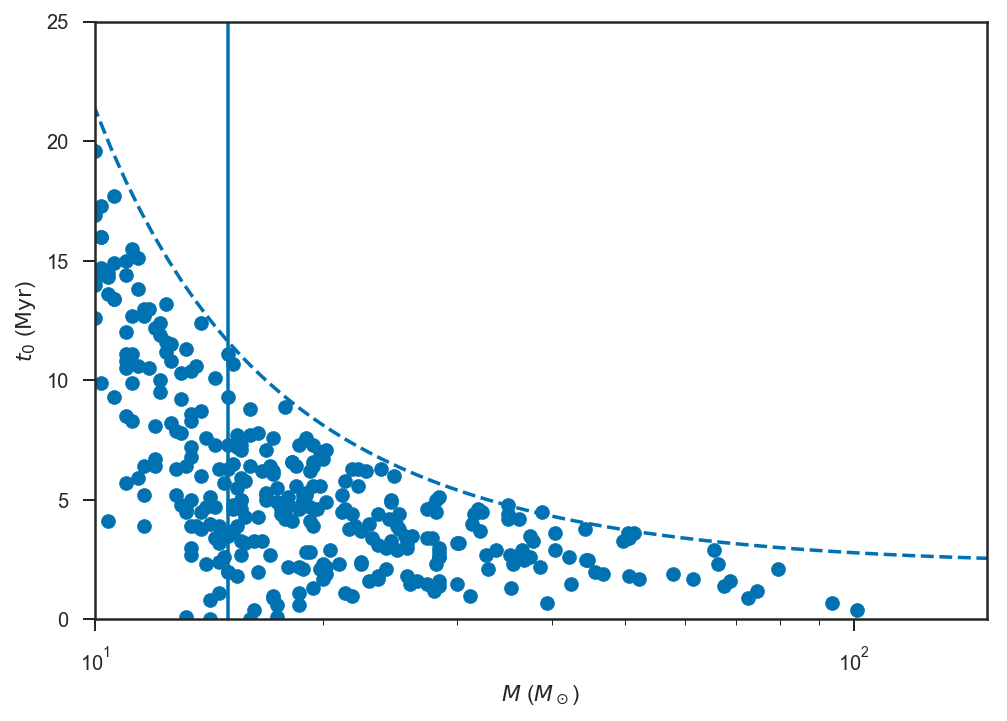

In [10]:
plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T)), '--', label='Fit')
xscale('log')
scatter(stellar_parameters['Mini'], stellar_parameters['age'])

axis(xmin=10, xmax=150, ymax=25, ymin=0)

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')

axvline(15) # Completeness line.

savefig('lifetime-data.pdf')

It seems reasonable enough that this population ($M \geq 10 \, \MSun$) is subject only to two selection effects: 

* The formation time must be smaller than the main-sequence lifetime ($t_0 \leq \tau(M)$) so the star is still on (or just off, since the giant phase is very short) the main sequence.
* If $M \lesssim 15 \, \MSun$ then the formation time must be sufficiently long ago that the star is bright enough to be observed in the survey:
$$
t_0 \geq \tau_0 \left( 15 \, \MSun - M \right)^\beta
$$
for some constants $\tau_0$ and $\beta > 0$, which we can fit from the data.

We will return to the lower limit on time for smaller masses; for now, let's focus on the supposedly complete sample, with $M > 15 \, \MSun$.

The model is implemented in `IMF.stan`.  Here are a few notes about how the model works.  First, we use a population model that is 
$$
\diff{N}{M \dd t} = \Lambda \frac{\alpha - 1}{M_\mathrm{min}} \left( \frac{M}{M_\mathrm{min}} \right)^{-\alpha} \frac{N\left( t \mid \mu_t, \sigma_t \right)}{\Phi\left( t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}
$$
In words: a power-law mass function and a Gaussian SFR, with expected number of stars formed with ages between $0$ and $t_\mathrm{max}$ of $\Lambda$.  Parameters are $\Lambda$, $\alpha$, $\mu_t$, $\sigma_t$.

We assume that the observational likelihood function is a product of Student-T distributions for log(mass) and age (independently), with location parameters at the quoted (MAP?) value, and scale parameters that are half the quoted 68% width.  This is lighter-tailed than some of the likelihoods presented in Schneider, et al. (2018), and is also symmetric unlike those distributions, but it is easy to implement.  (We can extend it later.)

To implement the selection effects, use direct integration.  We can analytically integrate over the *observable* region in parameter space in age, since the SFR is just a Gaussian (we get a difference of Gaussian CDFs).  Integrating over $M$ is not possible with simple functions, but we can use Stan's ODE computation to solve 
$$
\diff{f_\mathrm{obs}}{M} = \frac{\alpha - 1}{M_\mathrm{min}} \left( \frac{M}{M_\mathrm{min}} \right)^{-\alpha} \frac{\Phi\left( t_+(M) \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}{\Phi\left(t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}
$$
where $t_+(M)$ is the maximum lifetime for *observable* systems at mass $M$; $f_\mathrm{obs}(\infty)$ is the fraction of all stars formed that are *observable*, using the initial condition that $f_\mathrm{obs}\left(M_\mathrm{min}\right) = 0$.  The normalising term in the inhomogeneous Poisson distribution is then 
$$
\exp\left[ -\Lambda f_\mathrm{obs}(\infty) \right],
$$
or the expected number of *observed* systems.

To construct the likelihood described above, we produce fictituous $M_\mathrm{obs}$ and uncertainties so the likelihood is normal for $M$ and $t$ with the quoted 68% interval.

In [44]:
mupper = stellar_parameters['Mini'] + stellar_parameters['dMinip']
mlower = stellar_parameters['Mini'] - stellar_parameters['dMinim']

logm_obs = log(stellar_parameters['Mini'])
sigma_logm_obs = 0.5*(log(mupper) - log(mlower))

tupper = stellar_parameters['age'] + stellar_parameters['dagep']
tlower = stellar_parameters['age'] - stellar_parameters['dagem']

t_obs = stellar_parameters['age']
sigma_t_obs = 0.5*(tupper - tlower)

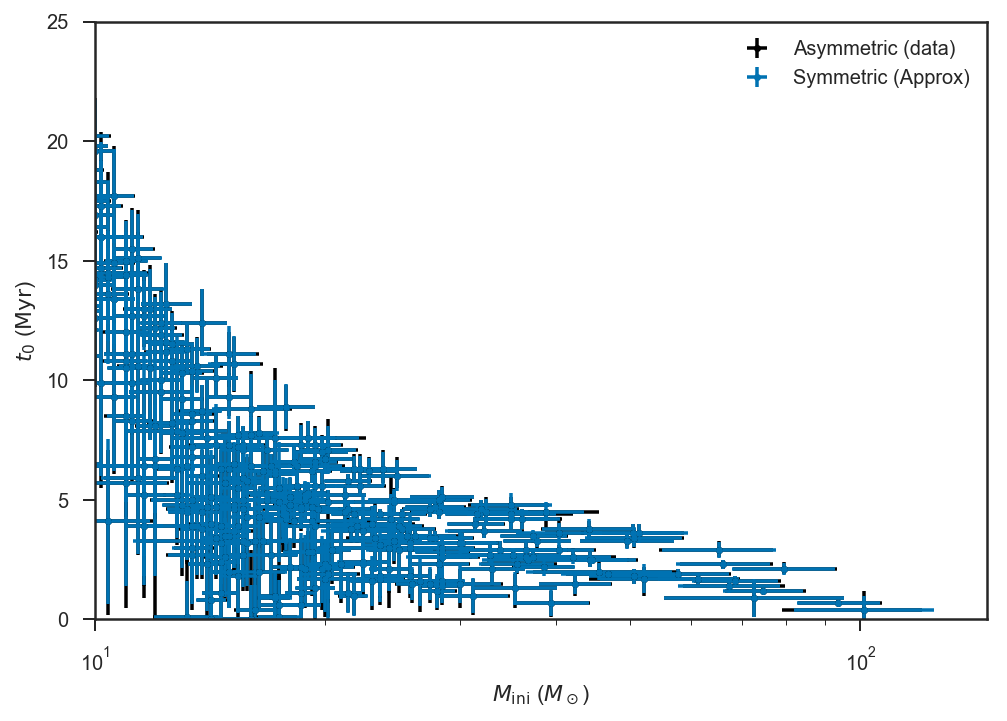

In [47]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', color='k', label="Asymmetric (data)")
errorbar(exp(logm_obs), t_obs, yerr=sigma_t_obs, xerr=(exp(logm_obs)-exp(logm_obs - sigma_logm_obs), -exp(logm_obs) + exp(logm_obs+sigma_logm_obs)), fmt='.', color=sns.color_palette()[0], label="Symmetric (Approx)")
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=10, ymin=0, ymax=25)
legend(loc='best')

## Fitting

First, some utility functions:

In [73]:
def dump_fit(model, fit, file):
    chain = fit.extract(permuted=True)
    
    with bz2.BZ2File(file, 'w') as out:
        pickle.dump(model, out)
        pickle.dump(fit, out)
        pickle.dump(chain, out)
        
def load_fit(file, return_model=False, return_chain=False):
    with bz2.BZ2File(file, 'r') as inp:
        model = pickle.load(inp)
        fit = pickle.load(inp)
        chain = pickle.load(inp)
        
    return (model, fit, chain)

The model we use is defined in `IMF.stan`.

In [51]:
model = pystan.StanModel(file='IMF.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_93eff1dec1adb36621cd833af9fb2cb4 NOW.


We only consider systems that have formed in the last $25 \, \Myr$, and select systems above $15 \, \MSun$ (mass at which the survey becomes complete) in their quoted (MAP?) mass.

In [49]:
MMin = 10.0
MComplete = 15.0

tMax = 25.0

sel = stellar_parameters['Mini'] > MComplete

nu_default = 100 # Very close to a Gaussian with 100 DOF.

In [50]:
data = {
    'nltc': len(c_lifetime),
    'ltc': c_lifetime,
    
    'nu': nu_default,
    
    'MMin': MComplete,
    'tmax': tMax,
    
    'nobs': count_nonzero(sel),
    'log_Mobs': logm_obs[sel],
    'sigma_logM': sigma_logm_obs[sel],
    'ageobs': t_obs[sel],
    'sigma_age': sigma_t_obs[sel],
}

In [52]:
fit = model.sampling(data=data, iter=2000, thin=1)

In [54]:
fit

Inference for Stan model: anon_model_93eff1dec1adb36621cd833af9fb2cb4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   307.56    0.48  30.53 253.96 286.07 305.11 326.98 371.69   4000    1.0
alpha                 2.27  2.6e-3   0.16   1.97   2.16   2.27   2.38    2.6   4000    1.0
mu_t                  4.44  3.5e-3   0.22   4.03   4.29   4.44    4.6   4.88   4000    1.0
sigma_t               2.16  3.4e-3   0.22   1.81   2.01   2.14   2.29   2.64   4000    1.0
Mtrue[0]             61.96    0.17  10.46  43.67  54.77  61.12  68.48  83.95   4000    1.0
Mtrue[1]             18.97    0.02   1.02  16.98   18.3  18.96  19.59  21.09   4000    1.0
Mtrue[2]             25.87    0.05   3.24   20.0  23.58  25.67  27.99  32.71   4000    1.0
Mtrue[3]             92.41    0.18  11.47  71.83   84.4   91.9  99.54 116.62   4000

In [55]:
chain = fit.extract(permuted=True)

In [58]:
dump_fit(model, fit, 'sampling.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


Now we do a "broad" fit, which has heavy tails ($\nu = 4$ means that moments of the likelihood above 3---skewness---are not defined).

In [60]:
data_broad = data.copy()
data_broad['nu'] = 4 # Just barely large enough to have a variance

In [61]:
fit_broad = model.sampling(data=data_broad, iter=2000, thin=1)

In [62]:
fit_broad

Inference for Stan model: anon_model_93eff1dec1adb36621cd833af9fb2cb4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   303.32    0.55  30.77 249.17 281.77  300.8 322.13 371.02   3111    1.0
alpha                 2.29  2.7e-3   0.17   1.97   2.18   2.29    2.4   2.64   4000    1.0
mu_t                  4.42  3.8e-3   0.21   4.01   4.27   4.41   4.56   4.85   3196    1.0
sigma_t               2.02  4.2e-3    0.2   1.69   1.88   2.01   2.14   2.48   2347    1.0
Mtrue[0]             59.74     0.2  12.52  34.84  52.01   59.8  67.19  84.65   4000    1.0
Mtrue[1]             18.97    0.03   1.29  16.33  18.24  18.95  19.62  21.64   1847    1.0
Mtrue[2]              25.8    0.07   3.97  18.84  23.34  25.57  27.91  34.87   3129    1.0
Mtrue[3]             91.18    0.27  16.83  58.46  81.92  90.85  100.0 125.44   4000

In [63]:
chain_broad = fit_broad.extract(permuted=True)

In [65]:
dump_fit(model, fit_broad, 'sampling-broad.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


Let's do one more run, where we restrict to $M \geq 20 \MSun$.

In [68]:
MComplete_high = 20

sel_high = stellar_parameters['Mini'] >= MComplete_high

data_high_mass = data.copy()

data_high_mass['MMin'] = MComplete_high

data_high_mass['nobs'] = count_nonzero(sel_high)
data_high_mass['log_Mobs'] = logm_obs[sel_high]
data_high_mass['sigma_logM'] = sigma_logm_obs[sel_high]
data_high_mass['ageobs'] = t_obs[sel_high]
data_high_mass['sigma_age'] = sigma_t_obs[sel_high]

In [69]:
fit_high_mass = model.sampling(data=data_high_mass, iter=2000, thin=1)

In [70]:
fit_high_mass

Inference for Stan model: anon_model_93eff1dec1adb36621cd833af9fb2cb4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                    167.3    0.33  21.14 131.73 152.36 165.27 179.57 214.09   4000    1.0
alpha                 2.55  3.5e-3   0.22   2.14    2.4   2.55    2.7   3.01   4000    1.0
mu_t                  3.67  3.7e-3   0.23   3.27   3.51   3.65   3.81   4.19   4000    1.0
sigma_t               1.68  3.9e-3   0.24   1.32   1.51   1.64    1.8   2.25   4000    1.0
Mtrue[0]             61.55    0.16  10.13  44.16  54.36  60.89  67.81  83.34   4000    1.0
Mtrue[1]             25.97    0.05    3.1  20.87  23.71  25.54  27.99  32.81   4000    1.0
Mtrue[2]              92.0    0.19  12.08  70.44  83.51   91.3  99.49 118.19   4000    1.0
Mtrue[3]             21.29    0.02   1.05  20.04  20.47  21.03  21.85  23.88   4000

In [71]:
chain_high_mass = fit_high_mass.extract(permuted=True)

In [74]:
dump_fit(model, fit_high_mass, 'sampling-high-mass.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


## Analysis

Some useful plotting code:

In [139]:
def plot_dNdM(chain, MMin=15.0, MMax=300.0, down_select=False, *args, **kwargs):
    ms = logspace(log10(MMin), log10(MMax), 1000)[newaxis,:]
    
    alphas = chain['alpha'][:,newaxis]
    Ls = chain['L'][:,newaxis]
    
    dNdMs = Ls*(alphas-1)/MMin*(ms/MMin)**(-alphas)
    
    if down_select:
        mu_t = chain['mu_t']
        sigma_t = chain['sigma_t']
        
        sfactors = array([(ss.norm.cdf(lifetime(m, c_lifetime), loc=mu_t, scale=sigma_t) - ss.norm.cdf(0, loc=mu_t, scale=sigma_t))/(ss.norm.cdf(tMax, loc=mu_t, scale=sigma_t)-ss.norm.cdf(0, loc=mu_t, scale=sigma_t)) for m in ms[0,:]])
    
        dNdMs = dNdMs * sfactors.T
        
    m = median(dNdMs, axis=0)
    h = percentile(dNdMs, 84.0, axis=0)
    hh = percentile(dNdMs, 97.5, axis=0)
    l = percentile(dNdMs, 16.0, axis=0)
    ll = percentile(dNdMs, 2.5, axis=0)
    
    ms = ms[0,:]
    
    line, = loglog(ms, m, *args, **kwargs)
    c = line.get_color()
    
    fill_between(ms, h, l, color=c, alpha=0.25)
    fill_between(ms, hh, ll, color=c, alpha=0.25)
    
    xlabel(r'$M$ ($M_\odot$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
    
def plot_dNdt(chain, tmax=25.0, down_select=False, *args, **kwargs):
    ts = linspace(0, tmax, 1000)[newaxis,:]
    
    Ls = chain['L'][:,newaxis]
    mu_t = chain['mu_t'][:,newaxis]
    sigma_t = chain['sigma_t'][:,newaxis]
    
    dNdts = Ls*ss.norm.pdf(ts, loc=mu_t, scale=sigma_t)/(ss.norm.cdf(tMax, loc=mu_t, scale=sigma_t) - ss.norm.cdf(0, loc=mu_t, scale=sigma_t))

    if down_select:
        alphas = chain['alpha'][:,newaxis]
        
        mupper = []
        for t in ts[0,:]:
            if t < lifetime(1000.0, c_lifetime):
                mupper.append(np.inf)
            else:
                mupper.append(so.brentq((lambda m: lifetime(m, c_lifetime)-t), 10.0, 1000.0))
        mupper = array(mupper)
        
        sfactors = 1-(mupper/MComplete)**(1-alphas)
        
        dNdts = dNdts * sfactors
    
    ts = ts[0,:]
    
    m = median(dNdts, axis=0)
    h = percentile(dNdts, 84.0, axis=0)
    hh = percentile(dNdts, 97.5, axis=0)
    l = percentile(dNdts, 16.0, axis=0)
    ll = percentile(dNdts, 2.5, axis=0)
    
    line, = plot(ts, m, *args, **kwargs)
    c = line.get_color()
    
    fill_between(ts, h, l, color=c, alpha=0.25)
    fill_between(ts, hh, ll, color=c, alpha=0.25)
    
    xlabel(r'$t$ ($\mathrm{Mya}$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')

Execute the cell below to re-load the fits.  If you want to be sure that the model code matches, you can change the `_` to `model` to re-load the model as well, but it is probably safer to re-run the cell above where the model is compiled.

In [75]:
_, fit, chain = load_fit('sampling.pkl.bz2')
_, fit_broad, chain_broad = load_fit('sampling-broad.pkl.bz2')
_, fit_high_mass, chain_high_mass = load_fit('sampling-high-mass.pkl.bz2')

First, the headline result.  Here we plot the inferred IMF and the *observed* 

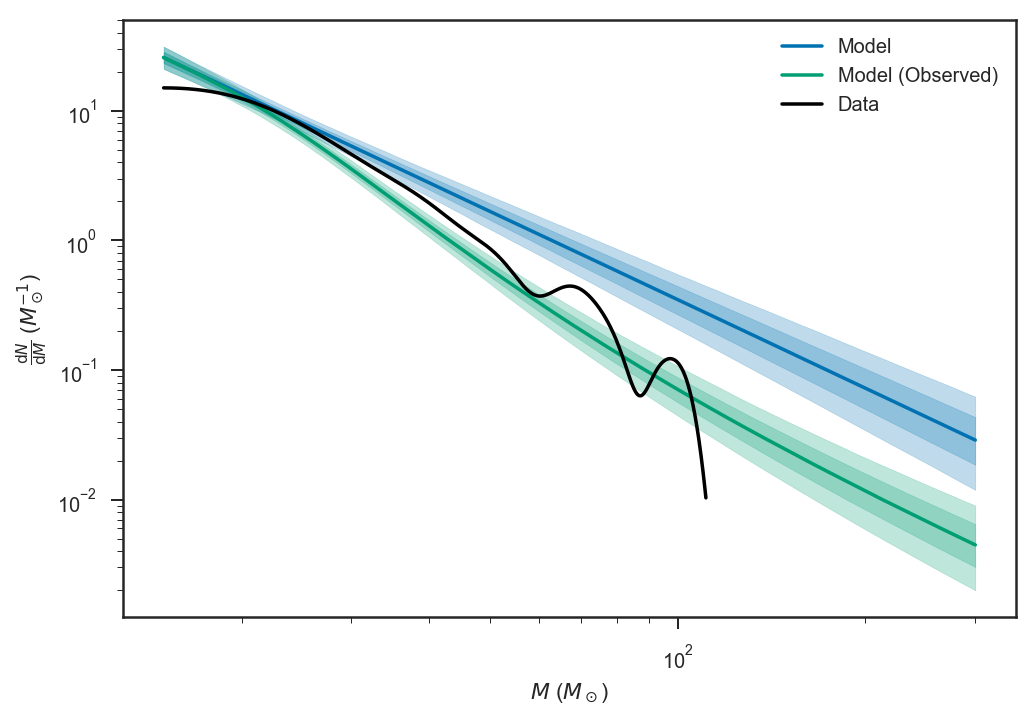

In [128]:
plot_dNdM(chain, label='Model')
plot_dNdM(chain, label='Model (Observed)', down_select=True)
ms = linspace(MComplete, np.max(stellar_parameters['Mini'])+10.0, 1000)
kde = ss.gaussian_kde(stellar_parameters['Mini'][stellar_parameters['Mini']>MComplete])
plot(ms, count_nonzero(stellar_parameters['Mini']>MComplete)*(kde(ms) + kde(2*MComplete-ms)), label='Data', color='k')
legend(loc='best')

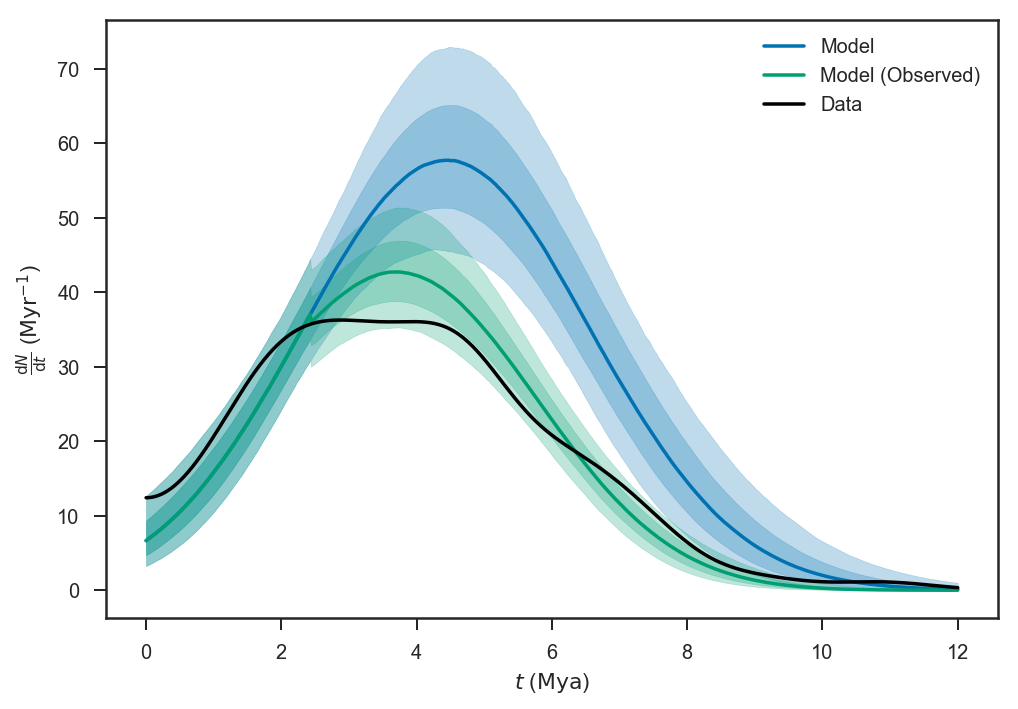

In [140]:
plot_dNdt(chain, tmax=12, label='Model')
plot_dNdt(chain, tmax=12, down_select=True, label='Model (Observed)')
ts = linspace(0, 12, 1000)
kde = ss.gaussian_kde(stellar_parameters['age'][stellar_parameters['Mini']>=MComplete])
plot(ts, count_nonzero(stellar_parameters['Mini']>MComplete)*(kde(ts) + kde(-ts)), color='k', label='Data')
legend(loc='best')

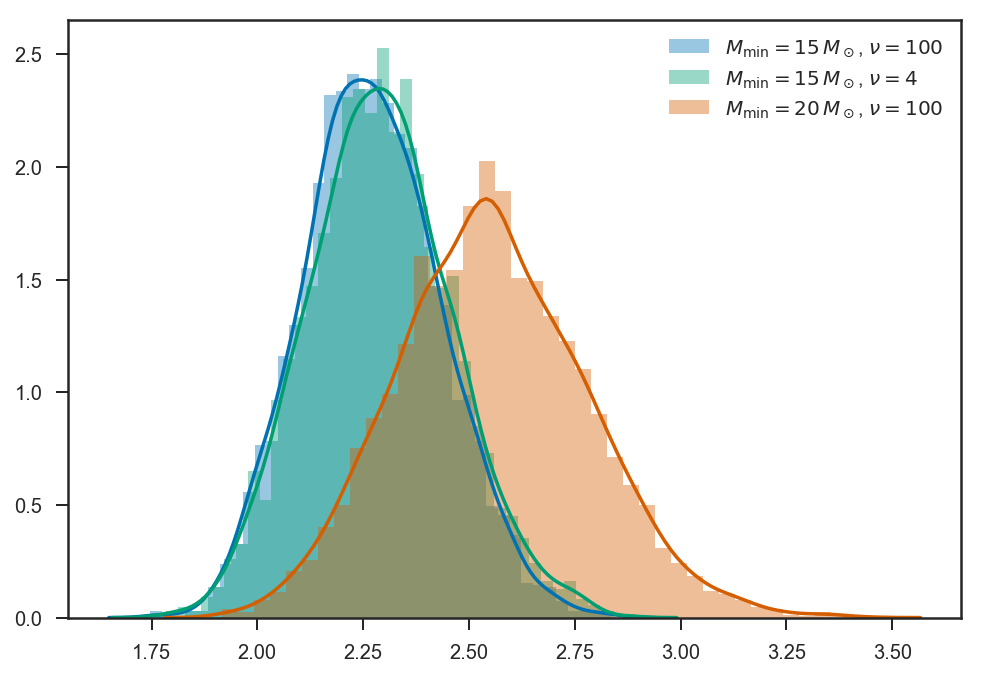

In [144]:
sns.distplot(chain['alpha'], label=r'$M_\mathrm{min} = 15 \, M_\odot$, $\nu = 100$')
sns.distplot(chain_broad['alpha'], label=r'$M_\mathrm{min} = 15 \, M_\odot$, $\nu = 4$')
sns.distplot(chain_high_mass['alpha'], label=r'$M_\mathrm{min} = 20 \, M_\odot$, $\nu = 100$')
legend(loc='best')